path found from forward
15.0 -80.0
14.862985924036074 -79.57151925979319
14.783215967618435 -79.12875804746326
14.886378009724153 -77.6338328138892
15.245505031909744 -76.17856441196774
16.0636495513041 -75.30795764529127
15.94677879059179 -74.56794080377098
16.10465731272164 -73.08188705232044
15.186231096232019 -77.2986393282154
15.594514753453977 -75.34906705282012
16.474196172927524 -72.60921186485875
14.970431339120648 -78.24846694622136
17.244265974362694 -71.68995205184856
17.640811884484418 -70.5580121197379
14.74519812036418 -78.52608662316298
17.784907214387857 -69.8233504096358
14.71929909433745 -78.68371277673849
18.35381307783981 -69.12611636594227
18.774379320521003 -69.14859293999017
18.974182073097342 -68.47418119116331
19.911405126584167 -67.72484188440826
15.241177459288162 -77.27844709827504
20.225653201083315 -67.2141241998901
15.024712578329268 -79.70102181983916
15.328728581331045 -78.69690903003222
14.695983148263904 -77.78571648423741
16.913331753187475 -72.4165

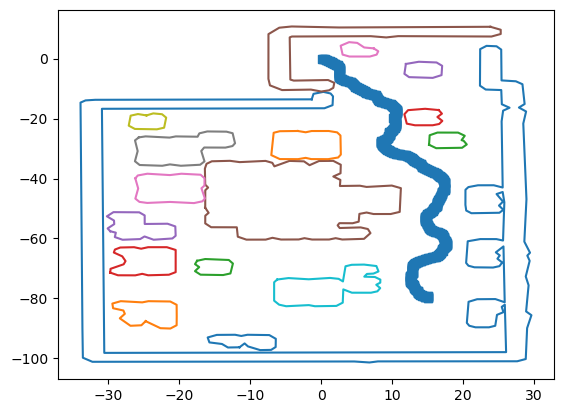

In [1]:
import shapely
import shapely.ops
import numpy as np
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import shape
from SST import SST
import time
from threading import Thread



def get_global_map():

    global_map_list = []
    schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
    }

    with fiona.open("/home/acsr/Documents/extended_polygon.shp") as shapefile:
        for record in shapefile:
            geometry = shape(record['geometry'])

            # if shapely.contains(geometry,shapely.Point(-28,-58)):
            #     continue
            global_map_list.append(geometry)
            # x5,y5 = geometry.exterior.xy
            # xi2,yi2 = geometry.interiors[0].xy
        map_shapely = shapely.unary_union(global_map_list)

        # print(type(map_shapely))
        
    
    # map_polygon = shapely.Polygon()
    return map_shapely

if __name__ == "__main__":
    global_map = get_global_map()
    # print(type(global_map))

    # get the start and end position
    start_point = shapely.Point(0,0,0)

    end_point = shapely.Point(15.0,-80,-1.57)

    wheel_base = 1.7
    v_range = [1.5,1.5]
    delta_range = [-0.5,0.5]
    max_running_time = 10
    min_running_time = 0
    bi_tree = True
    time_steps_range = [2,10]


    # create a RRT star search tree
    if shapely.contains(global_map,end_point) or shapely.contains(global_map,start_point):
        print("Invalid start or end position!")
    else:
        sst_path = SST(start_point,end_point,global_map,
                            wheel_base,
                            v_range,delta_range,
                            max_running_time,min_running_time,
                            bi_tree=bi_tree,time_steps_range=time_steps_range)

    get_reached = sst_path.get_tree_reached()

    current_time = time.time()
    find_solution = False
    final_path = None


    # while time.time()-current_time>min_running_time and time.time()-current_time<max_running_time and not find_solution:
    #     print("keep running planner")
    #     sst_path.get_forward_tree()
    #     # Thread(target=sst_path.get_forward_child_state).start()
    #     # Thread(target=sst_path.get_backward_child_state).start()
    
    if bi_tree:
        if get_reached[0]:
            final_path = sst_path.get_forward_final_trajectory()
        elif get_reached[1]:
            final_path = sst_path.get_backward_final_trajectory()
        else:
            print("no path returned")
    else:
        if get_reached:
            final_path = sst_path.get_forward_final_trajectory()
        else:
            print("no path returned")

    f_node_list = sst_path.get_forward_tree_node_list()
    if bi_tree:
        b_node_list = sst_path.get_backward_tree_node_list()

    # save the trajectory data to file

    if not final_path is None:

        s_file = open("/home/acsr/Documents/SST_data.txt","w")

        for n in final_path:
            s_file.write(str(n.x))
            s_file.write(",")
            s_file.write(str(n.y))
            s_file.write(",")
            s_file.write(str(n.z))
            s_file.write("\n")

        s_file.close()

    if not final_path is None:
        x_r = []
        y_r = []
        for n in final_path:
            x_r.append(n.x)
            y_r.append(n.y)
        plt.scatter(x_r,y_r,marker=",")
        
    for n in global_map.geoms:
        x,y = n.exterior.xy
        plt.plot(x,y)
    
    

    
    
    
    x_n = []
    y_n = []
    x_b = []
    y_b = []
    for n in f_node_list:
        

        x_n.append(n.pose.x)
        y_n.append(n.pose.y)
    # plt.scatter(x_n,y_n,marker="1")
    if bi_tree:
        for n in b_node_list:
        
            print(n.pose.x,n.pose.y)
            x_b.append(n.pose.x)
            y_b.append(n.pose.y)
        # plt.scatter(x_b,y_b,marker="2")
    plt.show()